## Leaf Classification - Relatório 2

Modelos lineares/simples:

* Bayesiano (sklearn.naive_bayes)

Modelo não-linear:

* KNeighborsClassifier

Árvore:

* Decision tree

Ensemble:

* Random Forests

Redes neurais:

* Multi-layer Perceptron ([sklearn.neural_network.MLPClassifier](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised))

SVM:

* SVC ([sklearn.svm](http://scikit-learn.org/stable/modules/svm.html#svm))

# Tratando os dados

As próximas duas céclulas preparam os dados pra rodar os classificadores. No final:

* `train` tem o conjunto de treinamento
* `labels` tem as respostas pra todas as amostras do conjunto de treinamento
* `test` e `test_ids` pode ignorar, seria importante só se a gente fosse fazer submit no kaggle
* `classes` tem a lista de classes existentes no nosso problema

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
# Swiss army knife function to organize the data

def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    classes = list(le.classes_)                    # save column names for submission
    test_ids = test.id                             # save test ids for submission
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return train, labels, test, test_ids, classes

train, labels, test, test_ids, classes = encode(train, test)

# Começam os testes

Importamos um bando de coisas: (métricas de avaliação)[http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics] (primeira linha de import), métodos de classificação (linhas 2 a 7 de import) e  umas utilidades pra fazer cross-validation(última linha de import).

Aí colocamos uma pá de classificadores num array e vamos testá-los. Ali embaixo defini uma função `crossValidate` pra fazer a cross-validation e printar as coisas bonitinho, **mas antes disso** criei aquele `folds`.

`folds` é a o que a cross-validation usa pra dividir o nosso conjunto sempre nos mesmos 10 subgrupos e fazer a mesma cross-validation. Não precisa se preocupar com isso.

## Sobre as métricas:

É uma boa revermos se essas métricas fazem sentido mesmo. Do jeito que elas estão sendo feitas ele calcula a métrica (precision ou recall respectivamente) pra cada classe e faz uma média de todos os valores achados pois, como pode se ver dentro da função `crossValidate`, elas estão sendo feitas com o parâmetro `average='macro'`. Existem outros parâmetros que podemos passar pra `average`, mas não sei se faz sentido. Mostrar *precision* e *average* pra cada classe com cada classificador ia ficar muita coisa e não ia ser nada esclarecedor...

Do jeito que está `recall_score` funciona igual funcionaria `accuracy_score`.

No notebook do Kaggle, o cara usa uma métrica (`log_loss`)[http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss], mas não cheguei a ler sobre ele e por que ela seria útil. Vale ressaltar que ela não usa como entrada o resultado default de `cross_val_predict`, por isso tive que fazer:

```
train_predictions_proba = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds, method='predict_proba')
print("LogLoss: ", log_loss(labels, train_predictions_proba))
```

*(comentei porque dava problema de overflow)*

In [3]:
from sklearn.metrics import accuracy_score, log_loss, recall_score, precision_recall_fscore_support, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict

classifiers = [
    ("3 n",KNeighborsClassifier(3)),
    ("rbf",SVC(kernel="rbf", C=0.025, probability=True)),
    ("",DecisionTreeClassifier()),
    ("10 trees",RandomForestClassifier()),
    ("100 trees",RandomForestClassifier(n_estimators=100)),
    ("",GaussianNB()),
    ("",LinearDiscriminantAnalysis())
]

MLPs = [
    ("(1)", MLPClassifier(hidden_layer_sizes=(1,))),
    ("(837)", MLPClassifier(hidden_layer_sizes=(837,)))
]

result_log = []

# Define a KFold for cross-validation
# Guarantees all cross validations are made with the same split
folds = StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

# Cross validation
def crossValidate(classifiers, train, labels, folds):
    for s,clf in classifiers:
        name = clf.__class__.__name__
    
        print("="*30)
        print(name+" "+s)
    
        print('****Results****')
        train_predictions = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds)#clf.predict(X_test)
        train_predictions_proba = cross_val_predict(clf, train, labels, n_jobs=-1, cv=folds, method='predict_proba')
        prec = precision_score(labels, train_predictions, average='macro')
        rec = recall_score(labels, train_predictions, average='macro')
        ll = log_loss(labels, train_predictions_proba)
        result_log.append([name+" "+s, prec, rec, ll])
        print("Precision: ", prec)
        print("Recall: ", rec)
        print("LogLoss: ", ll)
    
    print("="*30)

# Antes da padronização

KNeighborsClassifier 3 n
****Results****
Precision:  0.898580375853
Recall:  0.891919191919
LogLoss:  1.66908706585
SVC rbf
****Results****
Precision:  0.815300943805
Recall:  0.80101010101
LogLoss:  4.59862539708
DecisionTreeClassifier 
****Results****
Precision:  0.692425952274
Recall:  0.675757575758
LogLoss:  11.1989365887
RandomForestClassifier 10 trees
****Results****
Precision:  0.90249688583
Recall:  0.89797979798
LogLoss:  1.10704971974
RandomForestClassifier 100 trees
****Results****
Precision:  0.978124681155
Recall:  0.975757575758
LogLoss:  0.717990521095
GaussianNB 
****Results****
Precision:  0.750538610202
Recall:  0.611111111111
LogLoss:  13.4045550904
LinearDiscriminantAnalysis 
****Results****


/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder

Precision:  0.980466671376
Recall:  0.977777777778
LogLoss:  1.01430161414
MLPClassifier (1)
****Results****
Precision:  0.00134750713784
Recall:  0.020202020202
LogLoss:  4.34872602581
MLPClassifier (837)
****Results****
Precision:  0.962040372646
Recall:  0.957575757576
LogLoss:  0.192904663527


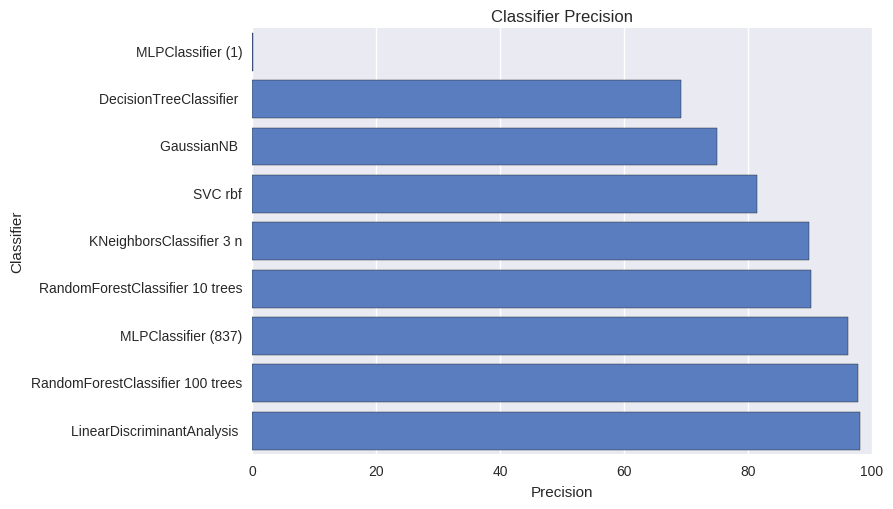

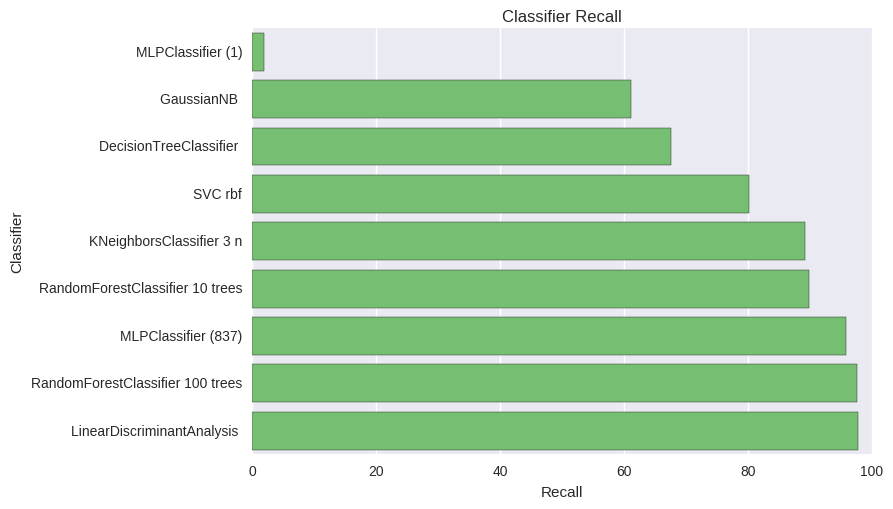

In [4]:
crossValidate(classifiers+MLPs, train, labels, folds)

result_prec=["Classifier", "Precision"]
prec_bars = pd.DataFrame(columns=result_prec)

for l in sorted(result_log, key=lambda x: float(x[1])):
    log_entry = pd.DataFrame([[l[0], l[1]*100]], columns=result_prec)
    prec_bars = prec_bars.append(log_entry)
    
result_rec=["Classifier", "Recall"]
rec_bars = pd.DataFrame(columns=result_rec)

for l in sorted(result_log, key=lambda x: float(x[2])):
    log_entry = pd.DataFrame([[l[0], l[2]*100]], columns=result_rec)
    rec_bars = rec_bars.append(log_entry)


    
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=prec_bars, color="b", ci=None)

plt.xlabel('Precision')
plt.title('Classifier Precision')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=rec_bars, color="g", ci=None)

plt.xlabel('Recall')
plt.title('Classifier Recall')
plt.show()

# Testes com redes neurais

A partir daqui testo com redes neurais (MultiLayer Perceptron)[http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.predict].

Primeiro pra 1 camada com os tamanhos 1, 99 e 198

# Depois de padronizar os dados

Aí eu li que padronizando seria melhor pq o MLP é sensível à escala. Usei esse StandardScaler do sklearn que padroniza automático e rodei de novo pra doi métodos lá de cima (que nos meus testes foram os únicos que se mostraram sensíveis à escala) e pras redes neurais de novo

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)

result_log = []

crossValidate(classifiers+MLPs, scaler.transform(train), labels, folds)

KNeighborsClassifier 3 n
****Results****
Precision:  0.976946622401
Recall:  0.973737373737
LogLoss:  0.288524036743
SVC rbf
****Results****
Precision:  0.98034423489
Recall:  0.977777777778
LogLoss:  4.6567523797
DecisionTreeClassifier 
****Results****
Precision:  0.693572529669
Recall:  0.679797979798
LogLoss:  11.059385977
RandomForestClassifier 10 trees
****Results****
Precision:  0.904178565542
Recall:  0.89696969697
LogLoss:  1.0793658704
RandomForestClassifier 100 trees
****Results****
Precision:  0.981756963575
Recall:  0.979797979798
LogLoss:  0.716689875931
GaussianNB 
****Results****
Precision:  0.75068648402
Recall:  0.612121212121
LogLoss:  13.3717353006
LinearDiscriminantAnalysis 
****Results****


/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder/local/main-venv/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:519: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/mseefelder

Precision:  0.980466671376
Recall:  0.977777777778
LogLoss:  1.01430161414
MLPClassifier (1)
****Results****
Precision:  0.00835542922092
Recall:  0.0262626262626
LogLoss:  4.09667005161
MLPClassifier (837)
****Results****
Precision:  0.989868380777
Recall:  0.988888888889
LogLoss:  0.0559073547021


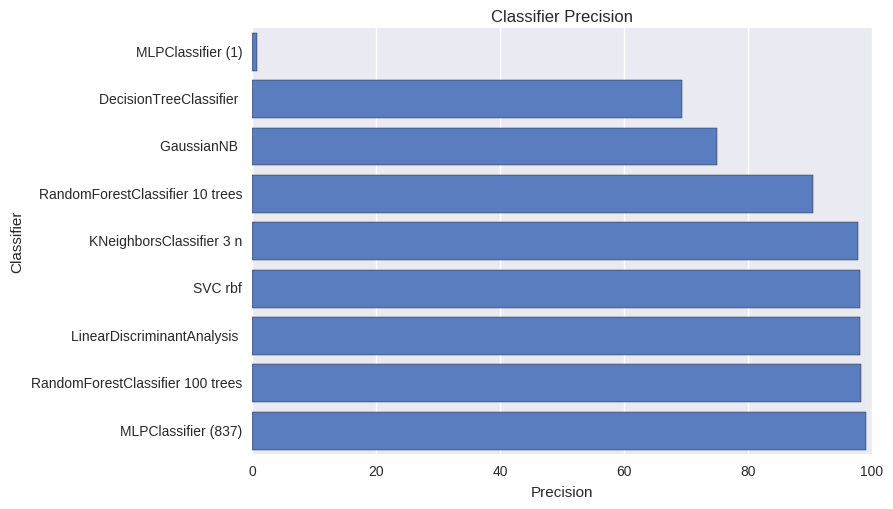

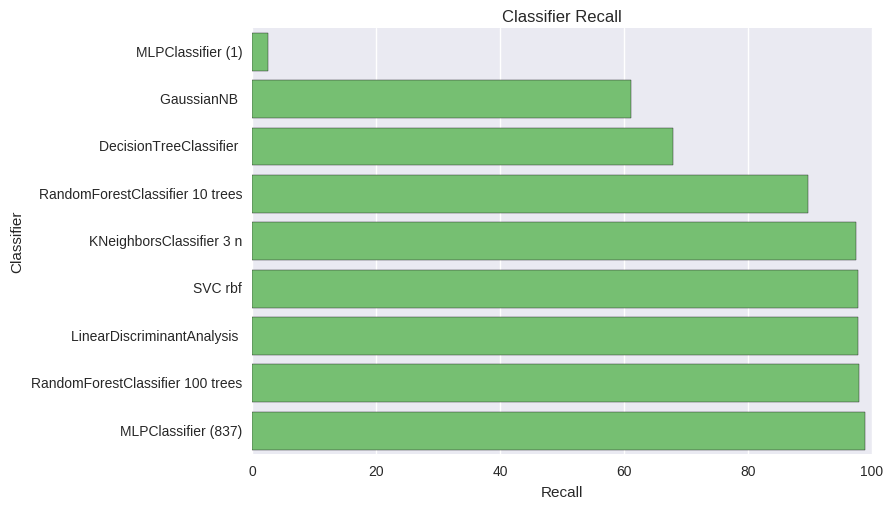

In [6]:
result_prec=["Classifier", "Precision"]
prec_bars = pd.DataFrame(columns=result_prec)

for l in sorted(result_log, key=lambda x: float(x[1])):
    log_entry = pd.DataFrame([[l[0], l[1]*100]], columns=result_prec)
    prec_bars = prec_bars.append(log_entry)
    
result_rec=["Classifier", "Recall"]
rec_bars = pd.DataFrame(columns=result_rec)

for l in sorted(result_log, key=lambda x: float(x[2])):
    log_entry = pd.DataFrame([[l[0], l[2]*100]], columns=result_rec)
    rec_bars = rec_bars.append(log_entry)


    
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=prec_bars, color="b", ci=None)

plt.xlabel('Precision')
plt.title('Classifier Precision')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=rec_bars, color="g", ci=None)

plt.xlabel('Recall')
plt.title('Classifier Recall')
plt.show()